<h1><center>Text classification using torchtext and torchero</center></h1>

This notebook was inspired from this [post](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

## Imports

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import text_classification

from torchero import SupervisedTrainer
from torchero.callbacks import ProgbarLogger
from torchero.callbacks.schedulers import *
from torchero.hparams import OptimP
from torchero.utils.data import train_test_split

### Load training dataset dataset ###

First, we download the AG_NEWS train and test datasets

In [2]:
NGRAMS = 2

if not os.path.isdir('./.data'):
    os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](root='./.data',
                                                                      ngrams=NGRAMS,
                                                                      vocab=None)

120000lines [00:04, 25315.81lines/s]
120000lines [00:07, 15031.74lines/s]
7600lines [00:00, 15177.62lines/s]


We split the training dataset into training and validation

In [3]:
train_dataset, val_dataset = train_test_split(train_dataset, valid_size=0.2)

Then we need to create the dataloaders for train, valid, and test dataset. For the use 

In [4]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return (text, offsets), label

train_dl = DataLoader(train_dataset, 100, collate_fn=generate_batch)
val_dl = DataLoader(val_dataset, 100, collate_fn=generate_batch)
test_dl = DataLoader(test_dataset, collate_fn=generate_batch)

## Model Definition

The model is an EmbeddingBag folled by a Linear unit (very simmilar to a word2vec architecture).

In [5]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

The number of classes can be extracted from the ``get_labels`` dataset method (4 in this case, "World", "Sports", "Business", "Sci/Tec")
and the vocab is extracted using the ``get_vocab`` method.

In [6]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 64
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS)

### Training

For the Trainer since it's a classification tasks we need ``'cross_entropy`` loss, and ``categorical_accuracy_percentage`` for the metric. The optimizer chosen is a SDG with a quite high learning rate. By using the ``StepLR`` callback we can decrease the lerarning rate 10% each epoch and only for the first ten epochs,
and then decreased it more rapidly by a factor of 50% them until epoch number 30 with a second ``StepLR`` callback.

In [7]:
trainer = SupervisedTrainer(model,
                            'cross_entropy',
                            optimizer=SGD(model.parameters(), lr=6.0),
                            callbacks=[ProgbarLogger(notebook=True),
                                       StepLR(1, gamma=0.9, end=10),
                                       StepLR(1, gamma=0.5, start=10, end=20)
                            ],
                            acc_meters=['categorical_accuracy_percentage'],
                            hparams={'lr': OptimP('lr')},
                            logging_frecuency=10)
trainer.to('cuda' if torch.cuda.is_available() else 'cpu')

Running the model...

In [8]:
trainer.train(train_dl, val_dl, epochs=30)

## Metrics ##

In [9]:
trainer.history.to_dataframe()

,epoch,train_acc,train_loss,lr,val_acc,val_loss
0,0,74.495834,0.652272,6.000000,87.845833,0.355057
1,1,89.971878,0.306462,5.400000,89.670830,0.300388
2,2,92.455208,0.234195,4.860000,90.329163,0.281671
3,3,94.144791,0.187207,4.374000,90.637497,0.274345
4,4,95.393745,0.152045,3.936600,90.750000,0.272325
5,5,96.462502,0.124739,3.542940,90.787498,0.272871
6,6,97.268745,0.103401,3.188646,90.916664,0.274672
7,7,97.903130,0.086807,2.869781,91.004166,0.277069
8,8,98.354164,0.073950,2.582803,91.037498,0.279716
9,9,98.684380,0.063969,2.324523,91.054169,0.282433


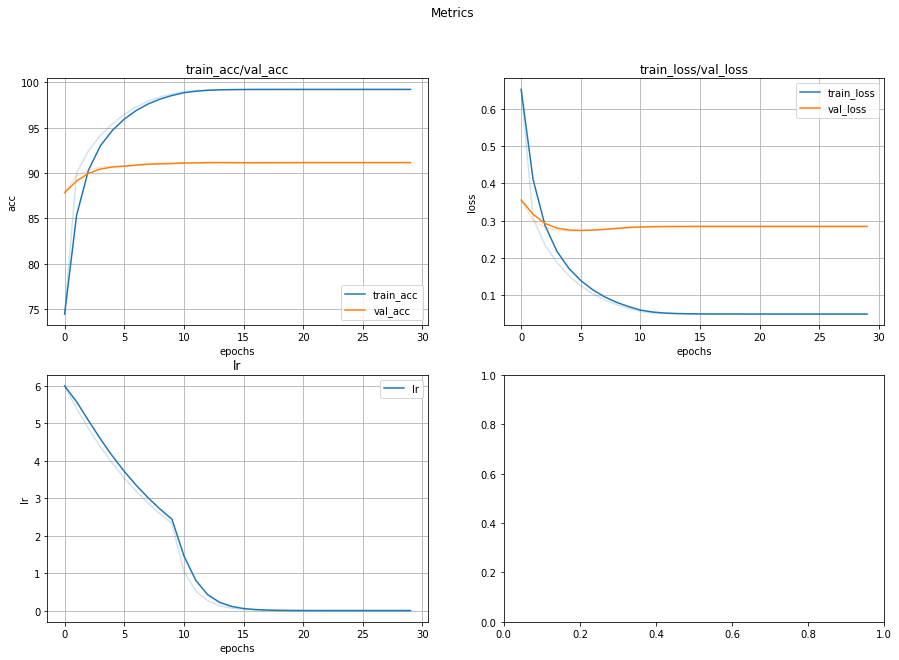

In [10]:
trainer.history.plot(smooth=0.3)
plt.show()

### Test Evaluation ###

In [15]:
results = trainer.evaluate_all({'Train': train_dl,
                                'Valid': val_dl,
                                'Test': test_dl}, metrics=['categorical_accuracy_percentage',
                                                           'confusion_matrix'])

### Accuracy ###

In [19]:
for split_name, metrics in results.items():
    print("{} accuracy: {:.2f}".format(split_name, metrics['acc']))

Train accuracy: 99.19
Valid accuracy: 91.15
Test accuracy: 88.95


### Confusion Matrix ###

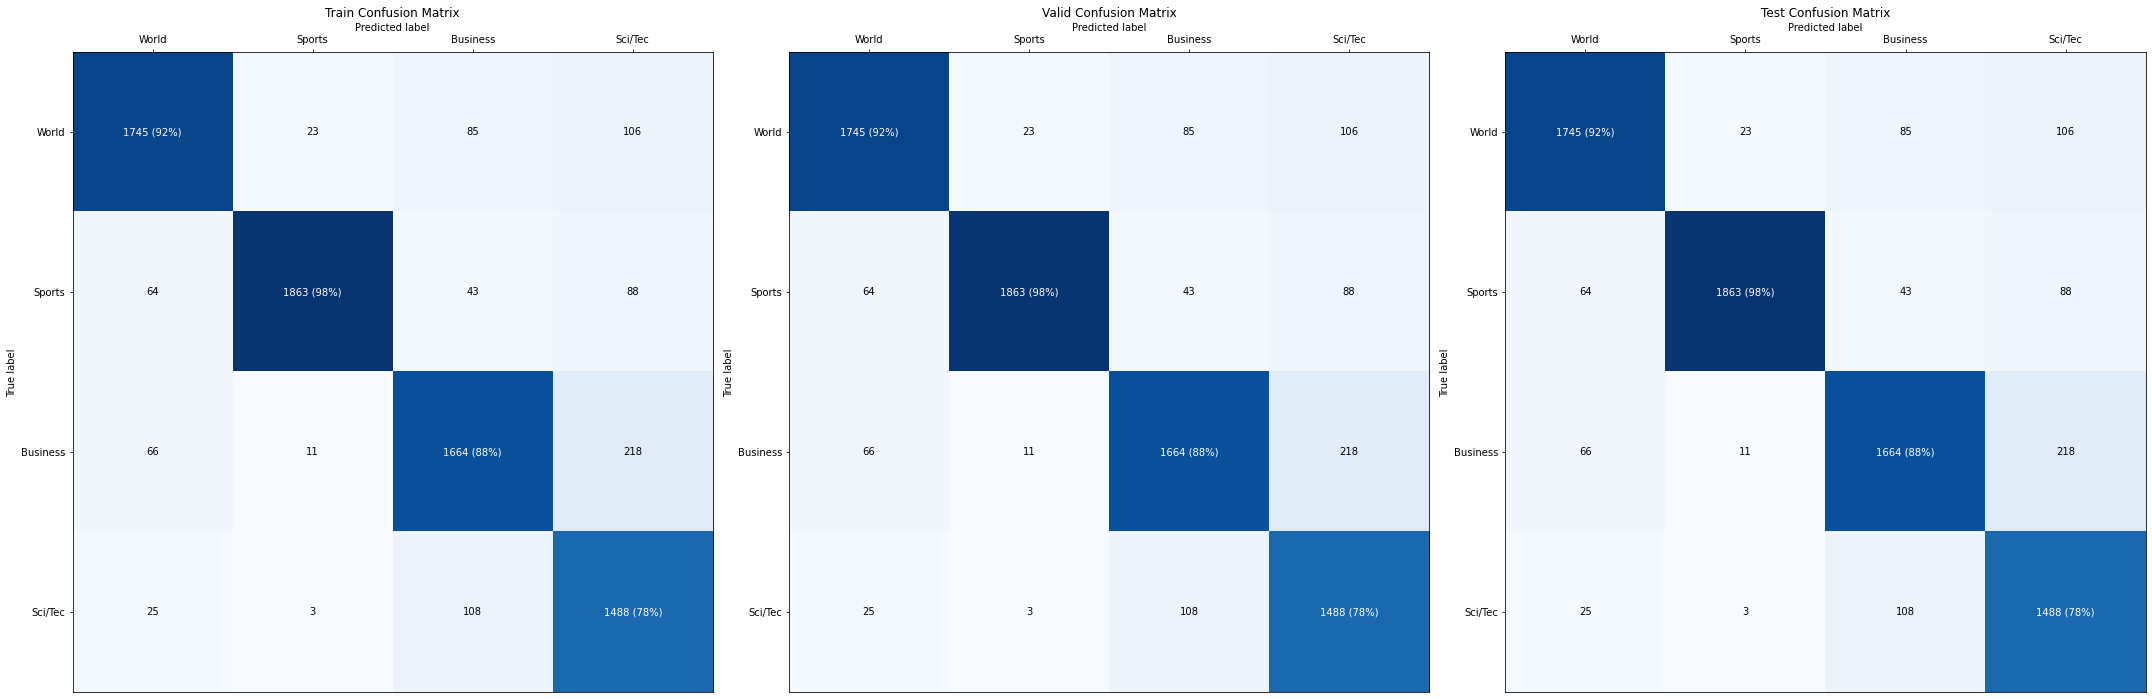

In [32]:
fig, axs = plt.subplots(figsize=(30, 20), ncols=3, nrows=1)
for (split_name, metrics), ax in zip(results.items(), axs):
    metrics['confusion_matrix'].plot(classes=["World",
                                              "Sports",
                                              "Business",
                                              "Sci/Tec"],
                                               ax=ax,
                                               fig=fig,
                                               title='{} Confusion Matrix'.format(split_name))
plt.tight_layout()
plt.show()